In [1]:
#2020, Ting Sun
#for Depp and Sun et al manuscript
#microglia bulk RNA sequencing
#raw fastq files aligned to reference genome using STAR default parameters
#gene counts extracted by featureCounts

#sequenced genotypes (6-month-old)
#WT, CnpKO, 5xFAD, CnpKO x 5xFAD

#apply differential expression analysis to every pair of genotypes (using CnpKOx5xFAD vs CnpKO as example )
#by DESeq2 package
#summarize statistic result


In [1]:
library(dplyr)
library(DESeq2)
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl,

In [2]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /home/tsun/anaconda3/envs/bulk/lib/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggplot2_3.3.2               DESeq2_1.26.0              
 [3] SummarizedExperiment_1.16.1 DelayedArray_0.12.3        
 [5] BiocParallel_1.20.1         matrixStats_0.56.0         
 [7] Biobase_2.46.0              GenomicRanges_1.38.0       
 [9] GenomeInfoDb_1.22.1         IRanges_2

In [3]:
#read in raw counts matrix, sample meta.data list and gene annotation list
meta.data<-read.csv("./bulk_metadata.csv")
annot<-read.csv("./mouse_gene_ID_annotation.csv",
               stringsAsFactors = FALSE)
raw<-read.csv("./2020_AD_microglia_raw_counts.csv")

In [4]:
meta.data
head(annot)
head(raw)
colnames(raw)

X,file_name,seq_number,genotype,sample
<int>,<fct>,<int>,<fct>,<fct>
1,p833s1_Nave_S42_L005_R1_001.fastq.gz.tabular,1,WT,WT_1
9,p833s2_Nave_S43_L005_R1_001.fastq.gz.tabular,2,WT,WT_2
10,p833s3_Nave_S44_L005_R1_001.fastq.gz.tabular,3,WT,WT_3
11,p833s4_Nave_S45_L005_R1_001.fastq.gz.tabular,4,WT,WT_4
12,p833s5_Nave_S46_L005_R1_001.fastq.gz.tabular,5,Cnp_ko,Cnp_ko_5
13,p833s6_Nave_S47_L005_R1_001.fastq.gz.tabular,6,Cnp_ko,Cnp_ko_6
14,p833s7_Nave_S48_L005_R1_001.fastq.gz.tabular,7,Cnp_ko,Cnp_ko_7
15,p833s8_Nave_S49_L005_R1_001.fastq.gz.tabular,8,Cnp_ko,Cnp_ko_8
16,p833s9_Nave_S50_L005_R1_001.fastq.gz.tabular,9,5xFAD,5xFAD_9


,X,ensembl_gene_id,mgi_symbol,chromosome_name,strand,start_position,end_position,gene_biotype
,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
1,1,ENSMUSG00000064336,mt-Tf,MT,1,1,68,Mt_tRNA
2,2,ENSMUSG00000064337,mt-Rnr1,MT,1,70,1024,Mt_rRNA
3,3,ENSMUSG00000064338,mt-Tv,MT,1,1025,1093,Mt_tRNA
4,4,ENSMUSG00000064339,mt-Rnr2,MT,1,1094,2675,Mt_rRNA
5,5,ENSMUSG00000064340,mt-Tl1,MT,1,2676,2750,Mt_tRNA
6,6,ENSMUSG00000064341,mt-Nd1,MT,1,2751,3707,protein_coding


,X,gene_symbol,WT_1,WT_2,WT_3,WT_4,Cnp_ko_5,Cnp_ko_6,Cnp_ko_7,Cnp_ko_8,X5xFAD_9,X5xFAD_10,X5xFAD_11,X5xFAD_12,Cnp_5xFAD_13,Cnp_5xFAD_14,Cnp_5xFAD_15,Cnp_5xFAD_16
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,ENSMUSG00000000001,Gnai3,3535,3024,1589,2524,3886,1189,2897,1402,3142,3163,540,1241,1459,1162,1033,1067
2,ENSMUSG00000000003,Pbsn,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ENSMUSG00000000028,Cdc45,98,60,55,59,87,14,72,34,128,134,13,45,44,38,41,28
4,ENSMUSG00000000031,H19,1,9,0,0,0,0,1,4,0,0,0,1,0,0,0,0
5,ENSMUSG00000000037,Scml2,36,8,0,11,7,1,0,15,3,10,9,1,4,2,0,4
6,ENSMUSG00000000049,Apoh,2,4,5,1,0,0,0,0,0,0,0,0,0,0,1,0


[1] "X"            "gene_symbol"  "WT_1"         "WT_2"         "WT_3"        
 [6] "WT_4"         "Cnp_ko_5"     "Cnp_ko_6"     "Cnp_ko_7"     "Cnp_ko_8"    
[11] "X5xFAD_9"     "X5xFAD_10"    "X5xFAD_11"    "X5xFAD_12"    "Cnp_5xFAD_13"
[16] "Cnp_5xFAD_14" "Cnp_5xFAD_15" "Cnp_5xFAD_16"

In [4]:
rownames(raw)<-raw$X
rownames(meta.data)<-meta.data$sample

In [5]:
colnames(raw)<-gsub("X","",colnames(raw))
colnames(raw)

[1] ""             "gene_symbol"  "WT_1"         "WT_2"         "WT_3"        
 [6] "WT_4"         "Cnp_ko_5"     "Cnp_ko_6"     "Cnp_ko_7"     "Cnp_ko_8"    
[11] "5xFAD_9"      "5xFAD_10"     "5xFAD_11"     "5xFAD_12"     "Cnp_5xFAD_13"
[16] "Cnp_5xFAD_14" "Cnp_5xFAD_15" "Cnp_5xFAD_16"

In [6]:
#####################select pair genotypes for analysis
#examplie using CnpKOx5xFAD vs CnpKO
sampleTable <- data.frame(sample = meta.data$sample[c(5:8,13:16)],
                         condition = meta.data$genotype[c(5:8,13:16)])
rownames(sampleTable)<-sampleTable$sample

In [7]:
sampleTable

,sample,condition
,<fct>,<fct>
Cnp_ko_5,Cnp_ko_5,Cnp_ko
Cnp_ko_6,Cnp_ko_6,Cnp_ko
Cnp_ko_7,Cnp_ko_7,Cnp_ko
Cnp_ko_8,Cnp_ko_8,Cnp_ko
Cnp_5xFAD_13,Cnp_5xFAD_13,Cnp_5xFAD
Cnp_5xFAD_14,Cnp_5xFAD_14,Cnp_5xFAD
Cnp_5xFAD_15,Cnp_5xFAD_15,Cnp_5xFAD
Cnp_5xFAD_16,Cnp_5xFAD_16,Cnp_5xFAD


In [8]:
colnames(raw)[1]<-"X"
rownames(raw)<-raw$X
cts<-raw[,rownames(sampleTable)]
head(cts)

,Cnp_ko_5,Cnp_ko_6,Cnp_ko_7,Cnp_ko_8,Cnp_5xFAD_13,Cnp_5xFAD_14,Cnp_5xFAD_15,Cnp_5xFAD_16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,3886,1189,2897,1402,1459,1162,1033,1067
ENSMUSG00000000003,0,0,0,0,0,0,0,0
ENSMUSG00000000028,87,14,72,34,44,38,41,28
ENSMUSG00000000031,0,0,1,4,0,0,0,0
ENSMUSG00000000037,7,1,0,15,4,2,0,4
ENSMUSG00000000049,0,0,0,0,0,0,1,0


In [9]:
#apply DGE analysis using DESeq2 package
dds<-DESeqDataSetFromMatrix(countData = cts,
                                    colData = sampleTable,
                                    design = ~condition)

factor levels were dropped which had no samples


In [10]:
dds

class: DESeqDataSet 
dim: 55471 8 
metadata(1): version
assays(1): counts
rownames(55471): ENSMUSG00000000001 ENSMUSG00000000003 ...
  ENSMUSG00000118639 ENSMUSG00000118640
rowData names(0):
colnames(8): Cnp_ko_5 Cnp_ko_6 ... Cnp_5xFAD_15 Cnp_5xFAD_16
colData names(2): sample condition

In [12]:
##############
dds$condition<-relevel(dds$condition, ref = "Cnp_ko")

In [13]:
dds_result<-DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [14]:
#extract statistic result
res<-results(dds_result)

In [15]:
res

log2 fold change (MLE): condition Cnp 5xFAD vs Cnp ko 
Wald test p-value: condition Cnp 5xFAD vs Cnp ko 
DataFrame with 55471 rows and 6 columns
                            baseMean      log2FoldChange             lfcSE
                           <numeric>           <numeric>         <numeric>
ENSMUSG00000000001  1559.34046972118 -0.0157946066320022 0.143341505923618
ENSMUSG00000000003                 0                  NA                NA
ENSMUSG00000000028  41.5039282917149   0.574083870602662 0.356651256851704
ENSMUSG00000000031  0.55939392700539   -2.18537903528362  3.39804162125527
ENSMUSG00000000037  3.93900585635211  -0.546877269033553  1.35261680854946
...                              ...                 ...               ...
ENSMUSG00000118636 0.707005692596459  -0.384721962735069  2.32242220331432
ENSMUSG00000118637                 0                  NA                NA
ENSMUSG00000118638                 0                  NA                NA
ENSMUSG00000118639            

In [17]:
exp<-res
########################
colnames(exp)<-paste0("Cnp5xFAD_vs_Cnpko_",colnames(res))

In [18]:
exp

 
 
DataFrame with 55471 rows and 6 columns
                   Cnp5xFAD_vs_Cnpko_baseMean Cnp5xFAD_vs_Cnpko_log2FoldChange
                                    <numeric>                        <numeric>
ENSMUSG00000000001           1559.34046972118              -0.0157946066320022
ENSMUSG00000000003                          0                               NA
ENSMUSG00000000028           41.5039282917149                0.574083870602662
ENSMUSG00000000031           0.55939392700539                -2.18537903528362
ENSMUSG00000000037           3.93900585635211               -0.546877269033553
...                                       ...                              ...
ENSMUSG00000118636          0.707005692596459               -0.384721962735069
ENSMUSG00000118637                          0                               NA
ENSMUSG00000118638                          0                               NA
ENSMUSG00000118639                          0                               NA
ENSMUSG0

In [20]:
#order result based on adjP
res<-res[order(res$padj, decreasing = F),]

In [21]:
#filter result for significant regulated genes, use cut-off adjP<0.05
res
summary(res)

res_sig<-results(dds_result, alpha = 0.05)
summary(res_sig)

log2 fold change (MLE): condition Cnp 5xFAD vs Cnp ko 
Wald test p-value: condition Cnp 5xFAD vs Cnp ko 
DataFrame with 55471 rows and 6 columns
                            baseMean     log2FoldChange             lfcSE
                           <numeric>          <numeric>         <numeric>
ENSMUSG00000031425   1884.9767597741  -3.93671458581075 0.246014531516049
ENSMUSG00000037625  191.173535462697  -3.67700504305091  0.29002690112374
ENSMUSG00000026442  349.555460652756  -2.95661615135894 0.272163966199007
ENSMUSG00000027375  244.379951793621  -2.57641876820185  0.26417957012007
ENSMUSG00000018126  690.024090446332   2.81009755149968 0.294471382991884
...                              ...                ...               ...
ENSMUSG00000118636 0.707005692596459 -0.384721962735069  2.32242220331432
ENSMUSG00000118637                 0                 NA                NA
ENSMUSG00000118638                 0                 NA                NA
ENSMUSG00000118639                 0     


out of 30048 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1271, 4.2%
LFC < 0 (down)     : 1241, 4.1%
outliers [1]       : 136, 0.45%
low counts [2]     : 9462, 31%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 30048 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 756, 2.5%
LFC < 0 (down)     : 841, 2.8%
outliers [1]       : 136, 0.45%
low counts [2]     : 9462, 31%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



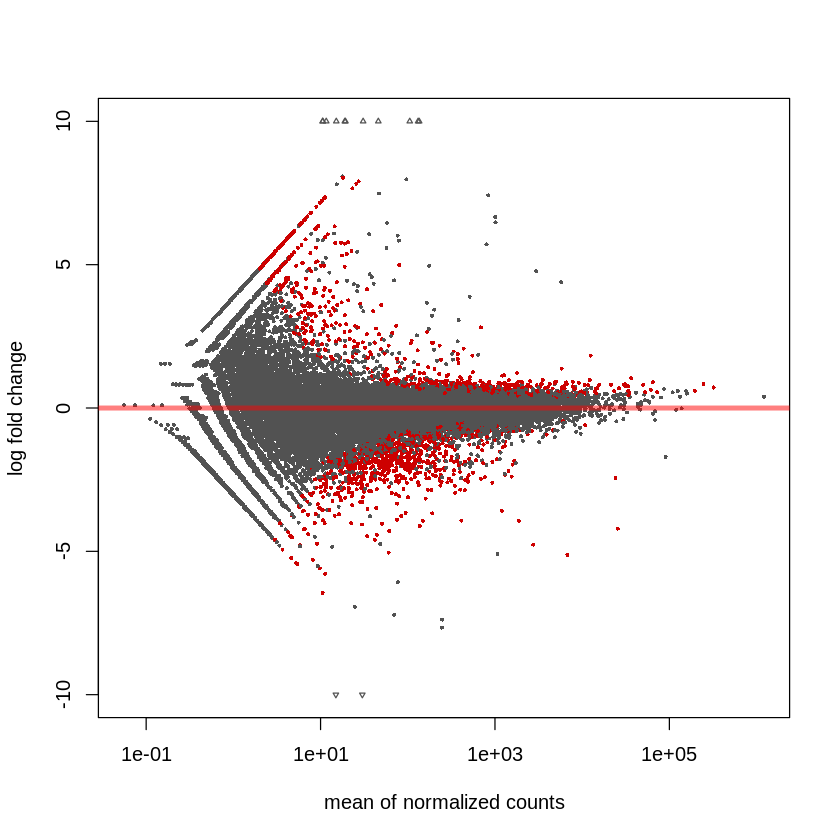

In [22]:
plotMA(res_sig, ylim = c(-10,10))

In [23]:
mcols(res_sig)

DataFrame with 6 rows and 2 columns
                       type
                <character>
baseMean       intermediate
log2FoldChange      results
lfcSE               results
stat                results
pvalue              results
padj                results
                                                         description
                                                         <character>
baseMean                   mean of normalized counts for all samples
log2FoldChange log2 fold change (MLE): condition Cnp 5xFAD vs Cnp ko
lfcSE                  standard error: condition Cnp 5xFAD vs Cnp ko
stat                   Wald statistic: condition Cnp 5xFAD vs Cnp ko
pvalue              Wald test p-value: condition Cnp 5xFAD vs Cnp ko
padj                                            BH adjusted p-values

In [24]:

#########################the following script aim to summarize statistics from CnpKOx5xFAD vs CnpKO
##########################together with gene raw counts and normalised counts

raw<-as.data.frame(counts(dds_result,normalized=F))
rld<-as.data.frame(counts(dds_result,normalized=T))

In [25]:
head(raw)
head(rld)

,Cnp_ko_5,Cnp_ko_6,Cnp_ko_7,Cnp_ko_8,Cnp_5xFAD_13,Cnp_5xFAD_14,Cnp_5xFAD_15,Cnp_5xFAD_16
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,3886,1189,2897,1402,1459,1162,1033,1067
ENSMUSG00000000003,0,0,0,0,0,0,0,0
ENSMUSG00000000028,87,14,72,34,44,38,41,28
ENSMUSG00000000031,0,0,1,4,0,0,0,0
ENSMUSG00000000037,7,1,0,15,4,2,0,4
ENSMUSG00000000049,0,0,0,0,0,0,1,0


,Cnp_ko_5,Cnp_ko_6,Cnp_ko_7,Cnp_ko_8,Cnp_5xFAD_13,Cnp_5xFAD_14,Cnp_5xFAD_15,Cnp_5xFAD_16
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,1731.626017,1448.11835,1730.0963936,1359.221004,1716.147149,1541.692063,1540.968497,1406.854279
ENSMUSG00000000003,0.000000,0.00000,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,38.767747,17.05102,42.9985987,32.962564,51.754952,50.416780,61.161383,36.918388
ENSMUSG00000000031,0.000000,0.00000,0.5972028,3.877949,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000037,3.119244,1.21793,0.0000000,14.542307,4.704996,2.653515,0.000000,5.274055
ENSMUSG00000000049,0.000000,0.00000,0.0000000,0.000000,0.000000,0.000000,1.491741,0.000000


In [26]:
for (i in 1:8){
    colnames(raw)[[i]]<-paste0(colnames(raw)[[i]],".","raw_counts")
    colnames(rld)[[i]]<-paste0(colnames(rld)[[i]],".","_normalised_value")
}

In [27]:
head(raw)
head(rld)

,Cnp_ko_5.raw_counts,Cnp_ko_6.raw_counts,Cnp_ko_7.raw_counts,Cnp_ko_8.raw_counts,Cnp_5xFAD_13.raw_counts,Cnp_5xFAD_14.raw_counts,Cnp_5xFAD_15.raw_counts,Cnp_5xFAD_16.raw_counts
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSMUSG00000000001,3886,1189,2897,1402,1459,1162,1033,1067
ENSMUSG00000000003,0,0,0,0,0,0,0,0
ENSMUSG00000000028,87,14,72,34,44,38,41,28
ENSMUSG00000000031,0,0,1,4,0,0,0,0
ENSMUSG00000000037,7,1,0,15,4,2,0,4
ENSMUSG00000000049,0,0,0,0,0,0,1,0


,Cnp_ko_5._normalised_value,Cnp_ko_6._normalised_value,Cnp_ko_7._normalised_value,Cnp_ko_8._normalised_value,Cnp_5xFAD_13._normalised_value,Cnp_5xFAD_14._normalised_value,Cnp_5xFAD_15._normalised_value,Cnp_5xFAD_16._normalised_value
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,1731.626017,1448.11835,1730.0963936,1359.221004,1716.147149,1541.692063,1540.968497,1406.854279
ENSMUSG00000000003,0.000000,0.00000,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,38.767747,17.05102,42.9985987,32.962564,51.754952,50.416780,61.161383,36.918388
ENSMUSG00000000031,0.000000,0.00000,0.5972028,3.877949,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000037,3.119244,1.21793,0.0000000,14.542307,4.704996,2.653515,0.000000,5.274055
ENSMUSG00000000049,0.000000,0.00000,0.0000000,0.000000,0.000000,0.000000,1.491741,0.000000


In [28]:
raw$gene_name<-rownames(raw)
rld$gene_name<-rownames(rld)
res$gene_name<-rownames(res)

In [29]:
res<-as.data.frame(res[rownames(raw),])

In [30]:
################################
colnames(res)[1:6]<-paste0("Cnp5xFAD_vs_Cnpko_",colnames(res)[1:6])

In [32]:
pre<-merge(x = res, y = raw, by = "gene_name")
all<-merge(x = pre, y = rld, by = "gene_name")

In [33]:
head(all)

gene_name,Cnp5xFAD_vs_Cnpko_baseMean,Cnp5xFAD_vs_Cnpko_log2FoldChange,Cnp5xFAD_vs_Cnpko_lfcSE,Cnp5xFAD_vs_Cnpko_stat,Cnp5xFAD_vs_Cnpko_pvalue,Cnp5xFAD_vs_Cnpko_padj,Cnp_ko_5.raw_counts,Cnp_ko_6.raw_counts,Cnp_ko_7.raw_counts,⋯,Cnp_5xFAD_15.raw_counts,Cnp_5xFAD_16.raw_counts,Cnp_ko_5._normalised_value,Cnp_ko_6._normalised_value,Cnp_ko_7._normalised_value,Cnp_ko_8._normalised_value,Cnp_5xFAD_13._normalised_value,Cnp_5xFAD_14._normalised_value,Cnp_5xFAD_15._normalised_value,Cnp_5xFAD_16._normalised_value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001,1559.3404697,-0.01579461,0.1433415,-0.1101886,0.9122598,0.9636215,3886,1189,2897,⋯,1033,1067,1731.626017,1448.11835,1730.0963936,1359.221004,1716.147149,1541.692063,1540.968497,1406.854279
ENSMUSG00000000003,0.0000000,NA,NA,NA,NA,NA,0,0,0,⋯,0,0,0.000000,0.00000,0.0000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000028,41.5039283,0.57408387,0.3566513,1.6096505,0.1074742,0.3188940,87,14,72,⋯,41,28,38.767747,17.05102,42.9985987,32.962564,51.754952,50.416780,61.161383,36.918388
ENSMUSG00000000031,0.5593939,-2.18537904,3.3980416,-0.6431290,0.5201404,NA,0,0,1,⋯,0,0,0.000000,0.00000,0.5972028,3.877949,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000000037,3.9390059,-0.54687727,1.3526168,-0.4043106,0.6859844,0.8487025,7,1,0,⋯,0,4,3.119244,1.21793,0.0000000,14.542307,4.704996,2.653515,0.000000,5.274055
ENSMUSG00000000049,0.1864676,1.54334765,3.5338115,0.4367374,0.6623018,NA,0,0,0,⋯,1,0,0.000000,0.00000,0.0000000,0.000000,0.000000,0.000000,1.491741,0.000000


In [34]:
#######################
all<-all[order(all$Cnp5xFAD_vs_Cnpko_padj, decreasing = F),]

In [35]:
head(all)

,gene_name,Cnp5xFAD_vs_Cnpko_baseMean,Cnp5xFAD_vs_Cnpko_log2FoldChange,Cnp5xFAD_vs_Cnpko_lfcSE,Cnp5xFAD_vs_Cnpko_stat,Cnp5xFAD_vs_Cnpko_pvalue,Cnp5xFAD_vs_Cnpko_padj,Cnp_ko_5.raw_counts,Cnp_ko_6.raw_counts,Cnp_ko_7.raw_counts,⋯,Cnp_5xFAD_15.raw_counts,Cnp_5xFAD_16.raw_counts,Cnp_ko_5._normalised_value,Cnp_ko_6._normalised_value,Cnp_ko_7._normalised_value,Cnp_ko_8._normalised_value,Cnp_5xFAD_13._normalised_value,Cnp_5xFAD_14._normalised_value,Cnp_5xFAD_15._normalised_value,Cnp_5xFAD_16._normalised_value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8346,ENSMUSG00000031425,1884.9768,-3.936715,0.2460145,-16.001960,1.238158e-57,2.532033e-53,8325,3279,5729,⋯,103,273,3709.6723,3993.5913,3421.3746,3031.5864,217.60605,192.37982,153.64933,359.95428
10784,ENSMUSG00000037625,191.1735,-3.677005,0.2900269,-12.678152,7.815309e-37,7.991153e-33,891,205,537,⋯,18,29,397.0352,249.6756,320.6979,450.8115,23.52498,22.55488,26.85134,38.23690
5551,ENSMUSG00000026442,349.5555,-2.956616,0.2721640,-10.863364,1.722839e-27,1.174402e-23,2042,498,954,⋯,49,70,909.9280,606.5290,569.7314,390.7033,70.57493,83.58571,73.09531,92.29597
6077,ENSMUSG00000027375,244.3800,-2.576419,0.2641796,-9.752528,1.799300e-22,9.198922e-19,965,360,634,⋯,28,76,430.0101,438.4547,378.6265,428.5133,87.04242,50.41678,41.76875,100.20705
1883,ENSMUSG00000018126,690.0241,2.810098,0.2944714,9.542854,1.389540e-21,5.668449e-18,387,168,219,⋯,1193,1065,172.4496,204.6122,130.7874,182.2636,1008.04531,638.17029,1779.64706,1404.21725
6343,ENSMUSG00000027858,159.7806,-3.162569,0.3320560,-9.524204,1.663115e-21,5.668449e-18,677,290,423,⋯,16,31,301.6755,353.1996,252.6168,243.3413,49.40245,13.26757,23.86786,40.87393


In [36]:
head(annot)

X,ensembl_gene_id,mgi_symbol,chromosome_name,strand,start_position,end_position,gene_biotype
<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>
1,ENSMUSG00000064336,mt-Tf,MT,1,1,68,Mt_tRNA
2,ENSMUSG00000064337,mt-Rnr1,MT,1,70,1024,Mt_rRNA
3,ENSMUSG00000064338,mt-Tv,MT,1,1025,1093,Mt_tRNA
4,ENSMUSG00000064339,mt-Rnr2,MT,1,1094,2675,Mt_rRNA
5,ENSMUSG00000064340,mt-Tl1,MT,1,2676,2750,Mt_tRNA
6,ENSMUSG00000064341,mt-Nd1,MT,1,2751,3707,protein_coding


In [37]:
all$ensembl_ID<-all$gene_name

In [38]:
for(i in 1:nrow(all)){
    position<-match(all$ensembl_ID[[i]], annot$ensembl_gene_id)
    all$gene_name[[i]]<-annot$mgi_symbol[position]
}

In [39]:
head(all)

,gene_name,Cnp5xFAD_vs_Cnpko_baseMean,Cnp5xFAD_vs_Cnpko_log2FoldChange,Cnp5xFAD_vs_Cnpko_lfcSE,Cnp5xFAD_vs_Cnpko_stat,Cnp5xFAD_vs_Cnpko_pvalue,Cnp5xFAD_vs_Cnpko_padj,Cnp_ko_5.raw_counts,Cnp_ko_6.raw_counts,Cnp_ko_7.raw_counts,⋯,Cnp_5xFAD_16.raw_counts,Cnp_ko_5._normalised_value,Cnp_ko_6._normalised_value,Cnp_ko_7._normalised_value,Cnp_ko_8._normalised_value,Cnp_5xFAD_13._normalised_value,Cnp_5xFAD_14._normalised_value,Cnp_5xFAD_15._normalised_value,Cnp_5xFAD_16._normalised_value,ensembl_ID
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
8346,Plp1,1884.9768,-3.936715,0.2460145,-16.001960,1.238158e-57,2.532033e-53,8325,3279,5729,⋯,273,3709.6723,3993.5913,3421.3746,3031.5864,217.60605,192.37982,153.64933,359.95428,ENSMUSG00000031425
10784,Cldn11,191.1735,-3.677005,0.2900269,-12.678152,7.815309e-37,7.991153e-33,891,205,537,⋯,29,397.0352,249.6756,320.6979,450.8115,23.52498,22.55488,26.85134,38.23690,ENSMUSG00000037625
5551,Nfasc,349.5555,-2.956616,0.2721640,-10.863364,1.722839e-27,1.174402e-23,2042,498,954,⋯,70,909.9280,606.5290,569.7314,390.7033,70.57493,83.58571,73.09531,92.29597,ENSMUSG00000026442
6077,Mal,244.3800,-2.576419,0.2641796,-9.752528,1.799300e-22,9.198922e-19,965,360,634,⋯,76,430.0101,438.4547,378.6265,428.5133,87.04242,50.41678,41.76875,100.20705,ENSMUSG00000027375
1883,Baiap2l2,690.0241,2.810098,0.2944714,9.542854,1.389540e-21,5.668449e-18,387,168,219,⋯,1065,172.4496,204.6122,130.7874,182.2636,1008.04531,638.17029,1779.64706,1404.21725,ENSMUSG00000018126
6343,Tspan2,159.7806,-3.162569,0.3320560,-9.524204,1.663115e-21,5.668449e-18,677,290,423,⋯,31,301.6755,353.1996,252.6168,243.3413,49.40245,13.26757,23.86786,40.87393,ENSMUSG00000027858


In [40]:
#just for OCD
all<-all[,c(24,1:23)]

In [41]:
head(all)

,ensembl_ID,gene_name,Cnp5xFAD_vs_Cnpko_baseMean,Cnp5xFAD_vs_Cnpko_log2FoldChange,Cnp5xFAD_vs_Cnpko_lfcSE,Cnp5xFAD_vs_Cnpko_stat,Cnp5xFAD_vs_Cnpko_pvalue,Cnp5xFAD_vs_Cnpko_padj,Cnp_ko_5.raw_counts,Cnp_ko_6.raw_counts,⋯,Cnp_5xFAD_15.raw_counts,Cnp_5xFAD_16.raw_counts,Cnp_ko_5._normalised_value,Cnp_ko_6._normalised_value,Cnp_ko_7._normalised_value,Cnp_ko_8._normalised_value,Cnp_5xFAD_13._normalised_value,Cnp_5xFAD_14._normalised_value,Cnp_5xFAD_15._normalised_value,Cnp_5xFAD_16._normalised_value
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8346,ENSMUSG00000031425,Plp1,1884.9768,-3.936715,0.2460145,-16.001960,1.238158e-57,2.532033e-53,8325,3279,⋯,103,273,3709.6723,3993.5913,3421.3746,3031.5864,217.60605,192.37982,153.64933,359.95428
10784,ENSMUSG00000037625,Cldn11,191.1735,-3.677005,0.2900269,-12.678152,7.815309e-37,7.991153e-33,891,205,⋯,18,29,397.0352,249.6756,320.6979,450.8115,23.52498,22.55488,26.85134,38.23690
5551,ENSMUSG00000026442,Nfasc,349.5555,-2.956616,0.2721640,-10.863364,1.722839e-27,1.174402e-23,2042,498,⋯,49,70,909.9280,606.5290,569.7314,390.7033,70.57493,83.58571,73.09531,92.29597
6077,ENSMUSG00000027375,Mal,244.3800,-2.576419,0.2641796,-9.752528,1.799300e-22,9.198922e-19,965,360,⋯,28,76,430.0101,438.4547,378.6265,428.5133,87.04242,50.41678,41.76875,100.20705
1883,ENSMUSG00000018126,Baiap2l2,690.0241,2.810098,0.2944714,9.542854,1.389540e-21,5.668449e-18,387,168,⋯,1193,1065,172.4496,204.6122,130.7874,182.2636,1008.04531,638.17029,1779.64706,1404.21725
6343,ENSMUSG00000027858,Tspan2,159.7806,-3.162569,0.3320560,-9.524204,1.663115e-21,5.668449e-18,677,290,⋯,16,31,301.6755,353.1996,252.6168,243.3413,49.40245,13.26757,23.86786,40.87393
